In [782]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [783]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
# !pip install d2l
# from d2l import torch as d2l
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline



In [784]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device2 = torch.device('cpu')

device

device(type='cuda')

In [785]:
#@save
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
def use_svg_display():  #@save
    """使用svg格式在Jupyter中显示绘图"""
    backend_inline.set_matplotlib_formats('svg')
def set_figsize(figsize=(3.5, 2.5)):  #@save
    """设置matplotlib的图表大小"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """绘制数据点"""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # 如果X有一个轴，输出True
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

In [786]:
train_data=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_data=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
train_data.shape,test_data.shape

((1460, 81), (1459, 80))

In [787]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [788]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features.shape

(2919, 79)

In [789]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [790]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [791]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [792]:
loss = nn.MSELoss()
in_features = train_features.shape[1]


def get_net():
    net = nn.Sequential(nn.Linear(in_features,1)).to(device)
    
    return net

In [793]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [794]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)

In [795]:
# net: 需要训练的神经网络模型
# train_features: 训练集的特征
# train_labels: 训练集的标签
# test_features: 测试集的特征
# test_labels: 测试集的标签
# num_epochs: 训练轮数
# learning_rate: 学习率
# weight_decay: 权重衰减
# batch_size: 批量大小
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [796]:
def get_k_fold_data(k, i, X, y):
    # 判断折数是否大于1，防止输入不合法
    assert k > 1
    # 计算每个折的大小
    fold_size = X.shape[0] // k
    # 初始化训练集和验证集
    X_train, y_train = None, None
    # 循环遍历所有折
    for j in range(k):
        # 计算验证集的下标
        idx = slice(j * fold_size, (j + 1) * fold_size)
        # 获取当前折的训练数据和标签
        X_part, y_part = X[idx, :], y[idx]
        # 如果当前是验证集，则直接返回该折的验证集数据和标签
        if j == i:
            X_valid, y_valid = X_part, y_part
        # 如果当前是训练集的第一折，则将当前折的数据和标签赋值给训练集
        elif X_train is None:
            X_train, y_train = X_part, y_part
        # 如果当前是训练集的其他折，则将当前折的数据和标签拼接到训练集中
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    # 返回训练集、验证集数据和标签
    return X_train, y_train, X_valid, y_valid


In [797]:

import time
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    # 初始化训练集和验证集的总损失
    train_l_sum, valid_l_sum = 0, 0
    # 遍历k个折
    for i in range(k):
        # 获取第i折的训练集和验证集
        data = get_k_fold_data(k, i, X_train, y_train)
        # 创建模型
        net = get_net()
        # 训练模型，并返回训练集和验证集的损失
        start_time = time.time()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        end_time = time.time()
        training_time = end_time - start_time
        # 记录训练集和验证集的总损失
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        # 在第一折时画出训练集和验证集损失曲线
        if i == 0:
            plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        # 打印第i折的训练集和验证集的损失
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
        print(f"模型训练花费的时间为：{training_time:.2f}秒")
    # 返回k折交叉验证后的平均训练集和验证集的损失
    return train_l_sum / k, valid_l_sum / k


In [798]:
# net: 需要训练的神经网络模型
# train_features: 训练集的特征
# train_labels: 训练集的标签
# test_features: 测试集的特征
# test_labels: 测试集的标签
# num_epochs: 训练轮数
# learning_rate: 学习率
# weight_decay: 权重衰减
# batch_size: 批量大小
# k, num_epochs, lr, weight_decay, batch_size = 10, 200, 5, 0, 64
# k, num_epochs, lr, weight_decay, batch_size = 5, 200, 5, 0, 64
# train_features=train_features.to(device)
# train_labels=train_labels.to(device)

# train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
#                           weight_decay, batch_size)
# print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
#       f'平均验证log rmse: {float(valid_l):f}')

折1，训练log rmse0.128633, 验证log rmse0.155489
模型训练花费的时间为：7.74秒
折2，训练log rmse0.128128, 验证log rmse0.154479
模型训练花费的时间为：8.40秒
折3，训练log rmse0.128414, 验证log rmse0.118472
模型训练花费的时间为：8.05秒
折4，训练log rmse0.129426, 验证log rmse0.114002
模型训练花费的时间为：7.89秒
折5，训练log rmse0.129334, 验证log rmse0.117677
模型训练花费的时间为：7.84秒
折6，训练log rmse0.128961, 验证log rmse0.136534
模型训练花费的时间为：8.31秒
折7，训练log rmse0.127625, 验证log rmse0.148321
模型训练花费的时间为：7.93秒
折8，训练log rmse0.126329, 验证log rmse0.169613
模型训练花费的时间为：7.78秒
折9，训练log rmse0.127005, 验证log rmse0.164206
模型训练花费的时间为：8.00秒
折10，训练log rmse0.126165, 验证log rmse0.161601
模型训练花费的时间为：8.26秒
折11，训练log rmse0.129215, 验证log rmse0.114848
模型训练花费的时间为：8.01秒
折12，训练log rmse0.128943, 验证log rmse0.123827
模型训练花费的时间为：7.78秒
折13，训练log rmse0.129197, 验证log rmse0.114152
模型训练花费的时间为：8.28秒
折14，训练log rmse0.128640, 验证log rmse0.139578
模型训练花费的时间为：7.90秒
折15，训练log rmse0.129039, 验证log rmse0.125194
模型训练花费的时间为：7.91秒
折16，训练log rmse0.128948, 验证log rmse0.142256
模型训练花费的时间为：7.72秒
折17，训练log rmse0.128466, 验证log rmse0.174353
模型训练花费

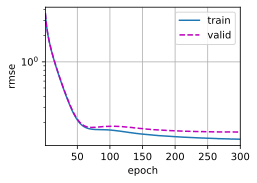

In [800]:
k, num_epochs, lr, weight_decay, batch_size = 20, 300, 5, 0, 64
train_features=train_features.to(device)
train_labels=train_labels.to(device)

train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [ ]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    # 获取神经网络
    net = get_net()
    # 训练神经网络，并返回训练误差和验证误差
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    # 画出训练误差的变化曲线
    plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    # 打印训练误差的最终结果
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集，预测房价
    preds = net(test_features).detach().to(device2).numpy()
    # 将预测的房价数据格式化，方便导出到CSV文件
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    # 导出预测结果到CSV文件中
    submission.to_csv('submission.csv', index=False)


In [ ]:
test_features=test_features.to(device)
# test_data= test_data.to(device)
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

In [ ]:
# import torch
# print(torch.cuda.is_available())